In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import numdifftools as nd
except:
    sys.stderr.write("Cannot load numdifftools.\n")

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from registration_utilities import *
from annotation_utilities import *

Cannot load numdifftools.


Setting environment for Precision WorkStation


No vtk


In [2]:
warp_setting = 17
detector_id = 15

In [3]:
# warp_properties = registration_settings.loc[warp_setting]
# print warp_properties

# upstream_warp_setting = warp_properties['upstream_warp_id']
# if upstream_warp_setting == 'None':
#     upstream_warp_setting = None
# else:
#     upstream_warp_setting = int(upstream_warp_setting)
    
# transform_type = warp_properties['transform_type']
# # terminate_thresh = warp_properties['terminate_thresh_trans']
# # grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
# # if not np.isnan(warp_properties['grid_search_sample_number']):
# #     grid_search_sample_number = int(warp_properties['grid_search_sample_number'])
# if not np.isnan(warp_properties['std_tx_um']):
#     std_tx_um = warp_properties['std_tx_um']
#     std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
# if not np.isnan(warp_properties['std_ty_um']):
#     std_ty_um = warp_properties['std_ty_um']
#     std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
# if not np.isnan(warp_properties['std_tz_um']):
#     std_tz_um = warp_properties['std_tz_um']
#     std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
# if not np.isnan(warp_properties['std_theta_xy_degree']):
#     std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
# if not np.isnan(warp_properties['max_iter_num']):
#     max_iter_num = int(warp_properties['max_iter_num'])
    
# try:
#     surround_weight = float(warp_properties['surround_weight'])
#     include_surround = surround_weight != 0 and not np.isnan(surround_weight)
# except:
#     surround_weight = str(warp_properties['surround_weight'])
#     include_surround = True

# # reg_weight = warp_properties['regularization_weight']
# # if np.isnan(reg_weight):
# #     reg_weights = np.zeros((3,))
# # else:
# #     reg_weights = np.ones((3,))*reg_weight

# print
# print 'surround', surround_weight
# # print 'regularization', reg_weights

# positive_weight = 'size'

In [30]:
stack_moving = 'atlasV5'

In [31]:
# Load all pre-computed z-scores.

zscores_all_stacks_all_structures_all_poolradius = defaultdict(dict)

for stack_fixed in all_nissl_stacks:
    for structure in all_known_structures_sided:
        try:
            zscores = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                                  detector_id_f=detector_id,
                                                  prep_id_f=2,
                                               warp_setting=warp_setting,
                                                structure_f=structure,
                                                  structure_m=structure,
                                               what='zscores')
            zscores = {float(i): t for i, t in zscores.iteritems()}
            zscores_all_stacks_all_structures_all_poolradius[stack_fixed][structure] = zscores
            
        except Exception as e:
            sys.stderr.write('Error loading confidence %s: %s.\n' % (structure, e))
                
zscores_all_stacks_all_structures_all_poolradius.default_factory = None

In [6]:
# Load all pre-computed hessians.

hessians_all_stacks_all_structures_all_stepsizes = defaultdict(dict)

for stack_fixed in all_nissl_stacks:
    for structure in all_known_structures_sided:
        try:
            hessians_all_stepsizes = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                                  detector_id_f=detector_id,
                                                  prep_id_f=2,
                                               warp_setting=warp_setting,
                                                structure_f=structure,
                                                  structure_m=structure,
                                               what='hessians')

            hessians_all_stepsizes = {float(i): t for i, t in hessians_all_stepsizes.iteritems()}
            hessians_all_stacks_all_structures_all_stepsizes[stack_fixed][structure] = hessians_all_stepsizes
            
        except Exception as e:
            sys.stderr.write('Error loading confidence %s: %s.\n' % (structure, e))
                
hessians_all_stacks_all_structures_all_stepsizes.default_factory = None

In [7]:
pool_radius_um_list = np.array([25, 50, 100, 150, 200, 300, 400])
stepsize_um_list = np.array([25, 50, 100, 150, 200, 300, 400])

In [38]:
peakradius_max_um_allstacks_allstructures_allsteps_allpools = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
peakradius_min_um_allstacks_allstructures_allsteps_allpools = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
peakradius_x_um_allstacks_allstructures_allsteps_allpools = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
peakradius_y_um_allstacks_allstructures_allsteps_allpools = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
peakradius_z_um_allstacks_allstructures_allsteps_allpools = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

peakradius_max_normalized_allstacks_allstructures_allsteps_allpools = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
peakradius_min_normalized_allstacks_allstructures_allsteps_allpools = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

# for stack in ['MD595']:
for stack in all_nissl_stacks:
#     for struct in ['7N_L']:
    for struct in all_known_structures_sided:
        
        print stack, struct
        
        stack_spec = dict(name=stack_fixed,
                   vol_type='score',
                   detector_id=15,
                   prep_id=2,
                   structure=None,
                   resolution='down32')
        alignedAtlas_vol_m2f = DataManager.load_transformed_volume(stack_m=stack_moving, stack_f=stack_fixed,
                                                        prep_id_f=2,
                                                        detector_id_f=detector_id,
                                                        warp_setting=17, 
                                                       structure=structure)
        
#         for step_um in stepsize_um_list:
#             for pool_um in pool_radius_um_list:
        for step_um in [25]:
            for pool_um in [100]:
#                 if step_um == pool_um:
                try:
                    H, fmax = hessians_all_stacks_all_structures_all_stepsizes[stack][struct][step_um]
                    z, fmax, mu, std = zscores_all_stacks_all_structures_all_poolradius[stack][struct][pool_um]

                    U, S, VT = np.linalg.svd(H/std)
#                     print step_um, z, fmax, mu, std, S, np.abs(np.linalg.det(H/std)), np.sqrt(2*(z-0)/S[-1]), np.sqrt(2*(z-0)/S[0])
#                     U, S, VT = np.linalg.svd(H)
#                     print step_um, z, fmax, mu, std, S, np.abs(np.linalg.det(H)), np.sqrt(2*(fmax-mu)/S[-1]), np.sqrt(2*(fmax-mu)/S[0])
#                     print 

                    peakradius_max_um_allstacks_allstructures_allsteps_allpools[stack][struct][step_um][pool_um] = np.sqrt(2*(z-0)/S[-1]) * XY_PIXEL_DISTANCE_TB
                    peakradius_min_um_allstacks_allstructures_allsteps_allpools[stack][struct][step_um][pool_um] = np.sqrt(2*(z-0)/S[0]) * XY_PIXEL_DISTANCE_TB
    
#                     print np.sqrt(2*(z-0)/S[-1]) , structure_length_least_certain_dir_down32Resol
                    structure_length_least_certain_dir_down32Resol = get_structure_length_at_direction(alignedAtlas_vol_m2f > 0.5, U[:, -1])
                    peakradius_max_normalized_allstacks_allstructures_allsteps_allpools[stack][struct][step_um][pool_um] = np.sqrt(2*(z-0)/S[-1]) / structure_length_least_certain_dir_down32Resol
                    peakradius_min_normalized_allstacks_allstructures_allsteps_allpools[stack][struct][step_um][pool_um] = np.sqrt(2*(z-0)/S[0]) / structure_length_least_certain_dir_down32Resol
        
                    peakradius_x_um_allstacks_allstructures_allsteps_allpools[stack][struct][step_um][pool_um] = np.sqrt(2*(z-0)/np.abs(H[0,0]/std)) * XY_PIXEL_DISTANCE_TB
                    peakradius_y_um_allstacks_allstructures_allsteps_allpools[stack][struct][step_um][pool_um] = np.sqrt(2*(z-0)/np.abs(H[1,1]/std)) * XY_PIXEL_DISTANCE_TB
                    peakradius_z_um_allstacks_allstructures_allsteps_allpools[stack][struct][step_um][pool_um] = np.sqrt(2*(z-0)/np.abs(H[2,2]/std)) * XY_PIXEL_DISTANCE_TB
                except Exception as e:
                    raise e
                    sys.stderr.write("Error computing confidence for %s,%s\n" % (stack, struct))

MD585 5N_L
MD585 5N_R
MD585 6N_L
MD585 6N_R
MD585 7N_L
MD585 7N_R
MD585 7n_L
MD585 7n_R
MD585 Amb_L
MD585 Amb_R
MD585 LC_L
MD585 LC_R
MD585 LRt_L
MD585 LRt_R
MD585 Pn_L
MD585 Pn_R
MD585 Tz_L
MD585 Tz_R
MD585 VLL_L
MD585 VLL_R
MD585 RMC_L
MD585 RMC_R
MD585 SNC_L
MD585 SNC_R
MD585 SNR_L
MD585 SNR_R
MD585 3N_L
MD585 3N_R
MD585 4N_L
MD585 4N_R
MD585 Sp5I_L
MD585 Sp5I_R
MD585 Sp5O_L
MD585 Sp5O_R
MD585 Sp5C_L
MD585 Sp5C_R
MD585 PBG_L
MD585 PBG_R
MD585 10N_L
MD585 10N_R
MD585 VCA_L
MD585 VCA_R
MD585 VCP_L
MD585 VCP_R
MD585 DC_L
MD585 DC_R
MD585 AP
MD585 12N
MD585 RtTg
MD585 SC
MD585 IC
MD589 5N_L
MD589 5N_R
MD589 6N_L
MD589 6N_R
MD589 7N_L
MD589 7N_R
MD589 7n_L
MD589 7n_R
MD589 Amb_L
MD589 Amb_R
MD589 LC_L
MD589 LC_R
MD589 LRt_L
MD589 LRt_R
MD589 Pn_L
MD589 Pn_R
MD589 Tz_L
MD589 Tz_R
MD589 VLL_L
MD589 VLL_R
MD589 RMC_L
MD589 RMC_R
MD589 SNC_L
MD589 SNC_R
MD589 SNR_L
MD589 SNR_R
MD589 3N_L
MD589 3N_R
MD589 4N_L
MD589 4N_R
MD589 Sp5I_L
MD589 Sp5I_R
MD589 Sp5O_L
MD589 Sp5O_R
MD589 Sp5C_L
MD589 S

In [13]:
save_data(peakradius_max_um_allstacks_allstructures_allsteps_allpools, '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_max_um_allstacks_allstructures_allsteps_allpools.json')
save_data(peakradius_max_normalized_allstacks_allstructures_allsteps_allpools, '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_max_normalized_allstacks_allstructures_allsteps_allpools.json')

save_data(peakradius_min_um_allstacks_allstructures_allsteps_allpools, '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_min_um_allstacks_allstructures_allsteps_allpools.json')
save_data(peakradius_min_normalized_allstacks_allstructures_allsteps_allpools, '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_min_normalized_allstacks_allstructures_allsteps_allpools.json')

save_data(peakradius_x_um_allstacks_allstructures_allsteps_allpools, '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_x_um_allstacks_allstructures_allsteps_allpools.json')
save_data(peakradius_y_um_allstacks_allstructures_allsteps_allpools, '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_y_um_allstacks_allstructures_allsteps_allpools.json')
save_data(peakradius_z_um_allstacks_allstructures_allsteps_allpools, '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_z_um_allstacks_allstructures_allsteps_allpools.json')

aws s3 cp "/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_max_um_allstacks_allstructures_allsteps_allpools.json" "s3://mousebrainatlas-data/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_max_um_allstacks_allstructures_allsteps_allpools.json"
return code: 0
aws s3 cp "/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_max_normalized_allstacks_allstructures_allsteps_allpools.json" "s3://mousebrainatlas-data/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_max_normalized_allstacks_allstructures_allsteps_allpools.json"
return code: 0
aws s3 cp "/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_min_um_allstacks_allstructures_allsteps_allpools.json" "s3://mousebrainatlas-data/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_min_um_allstacks_allstruc

# Plot z-score

In [32]:
pool_radius = 100
hessian_stepsize = 25

In [33]:
zscore_allstacks_allstructures_oneCombination = {
    stack:
    {struct: x[pool_radius][0]
    for struct, x in x_per_stack.iteritems()}
    for stack, x_per_stack in zscores_all_stacks_all_structures_all_poolradius.iteritems()
}

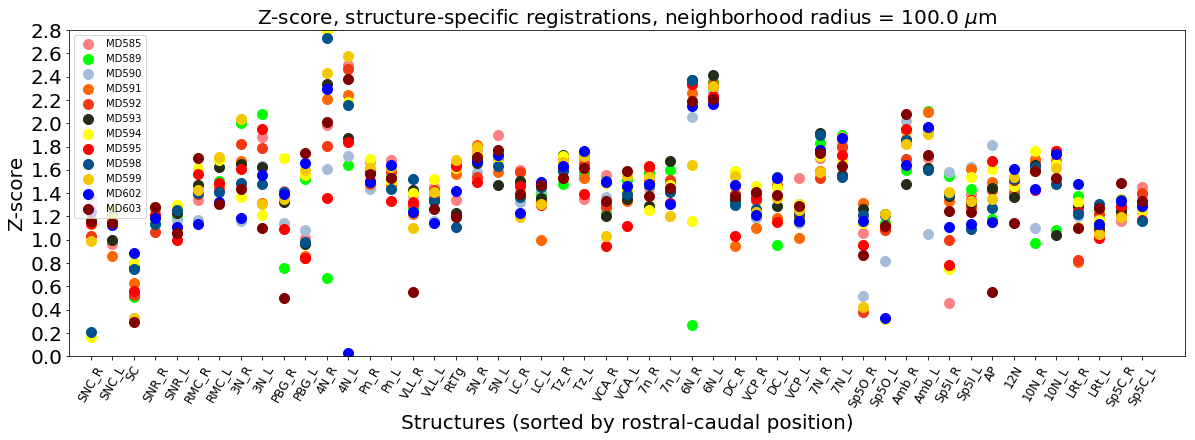

In [96]:
plot_by_stack_by_structure(zscore_allstacks_allstructures_oneCombination, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                          stack_to_color=stack_to_color,
                          yticks=np.arange(0, 3, .2),
                           yticklabel_fmt='%.1f',
                          ylabel='Z-score',
                          title='Z-score, structure-specific registrations, neighborhood radius = %.1f $\mu$m' % pool_radius,
                          xlabel='Structures (sorted by rostral-caudal position)',
                           xticks_fontsize=12,
                          );

In [20]:
print 'median local registration z-score:', np.nanmedian([y for x in zscore_allstacks_allstructures_oneCombination.values() for y in x.values()])

median local registration z-score: 1.412866365005278


# Identify high-confidence structures in one particular brain

In [21]:
for stack in all_nissl_stacks:
    print stack, np.count_nonzero(np.array(zscore_allstacks_allstructures_oneCombination[stack].values()) > 1.8)

MD585 8
MD589 6
MD590 5
MD591 8
MD592 6
MD593 5
MD594 5
MD595 6
MD598 6
MD599 7
MD602 5
MD603 5


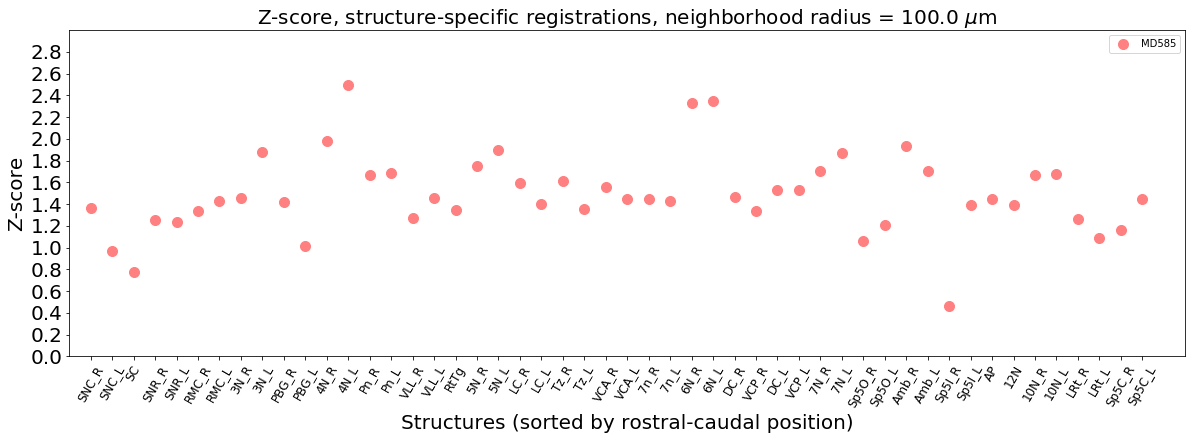

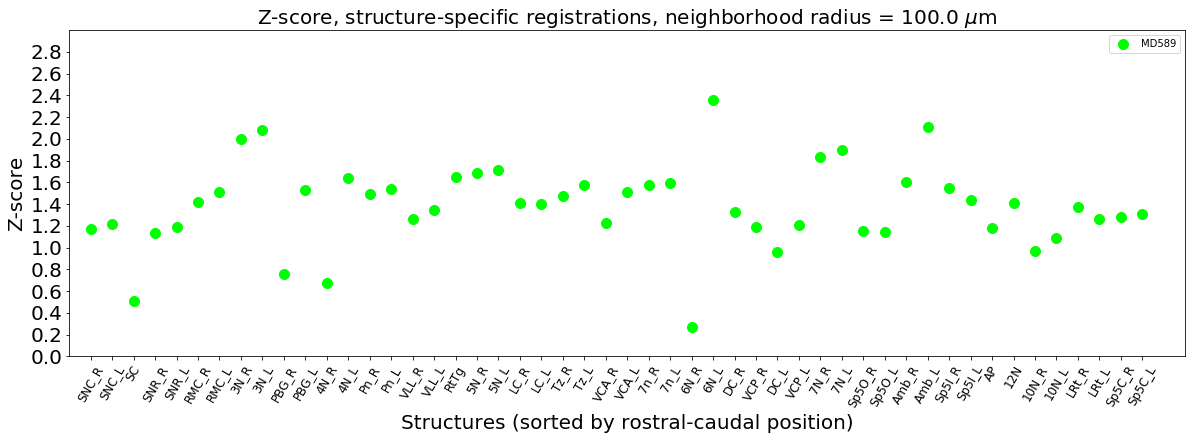

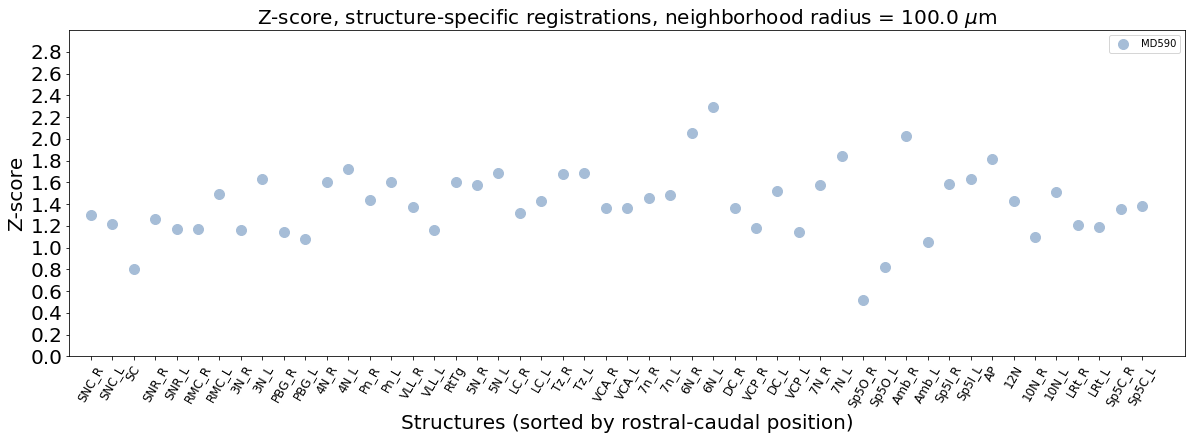

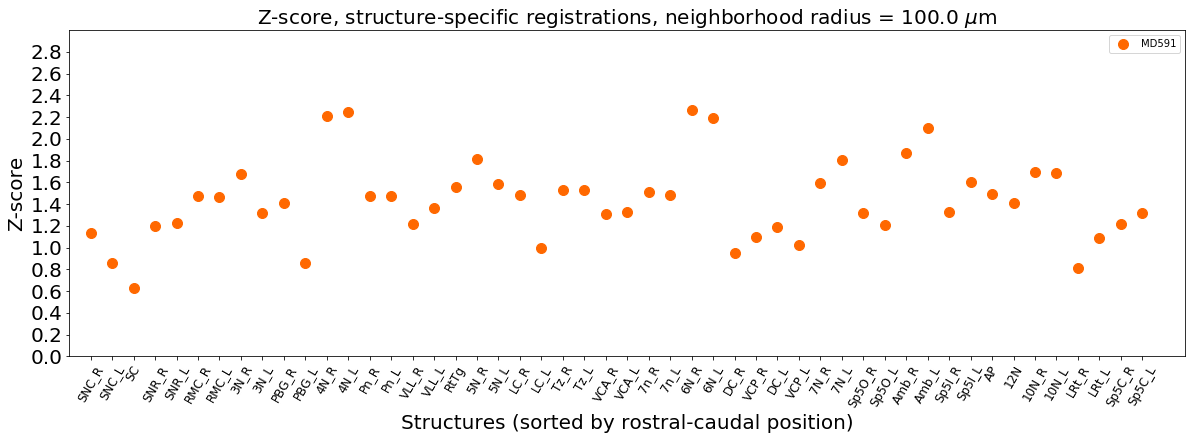

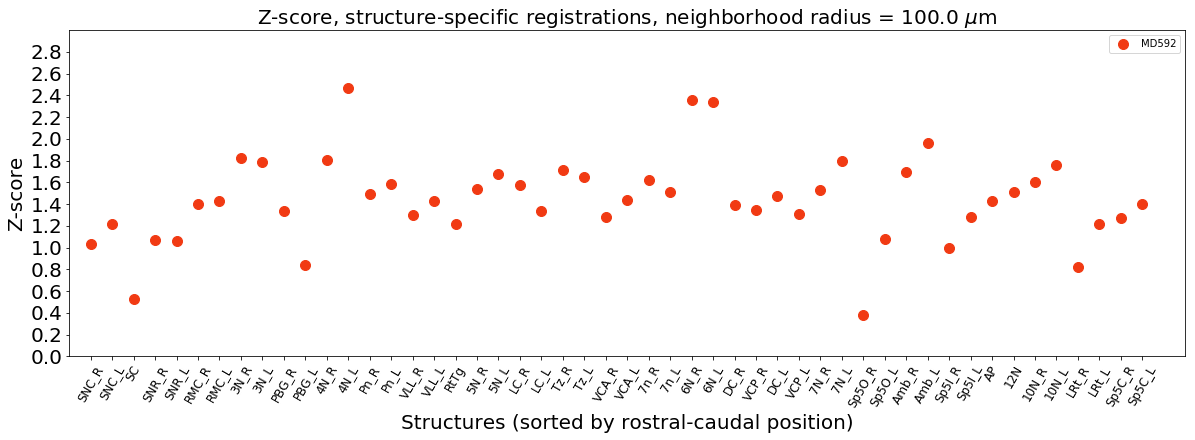

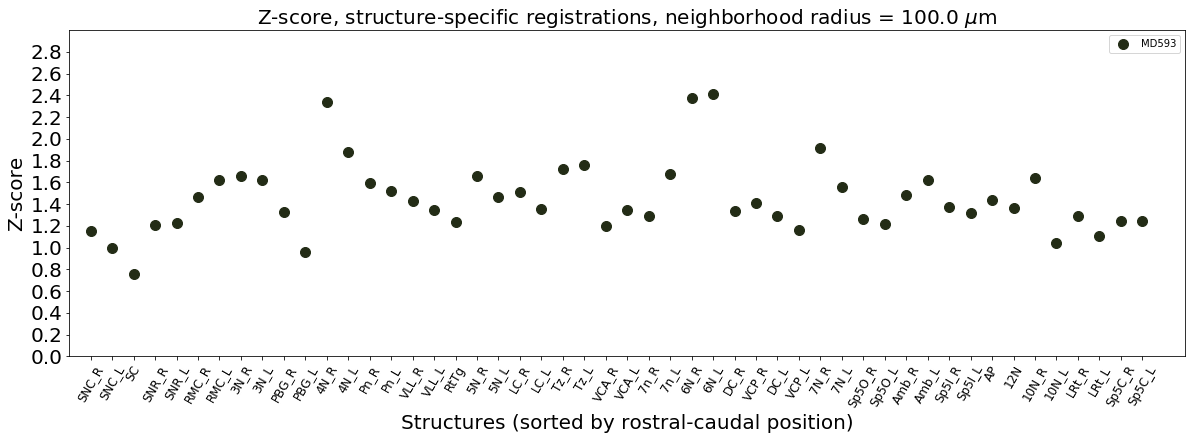

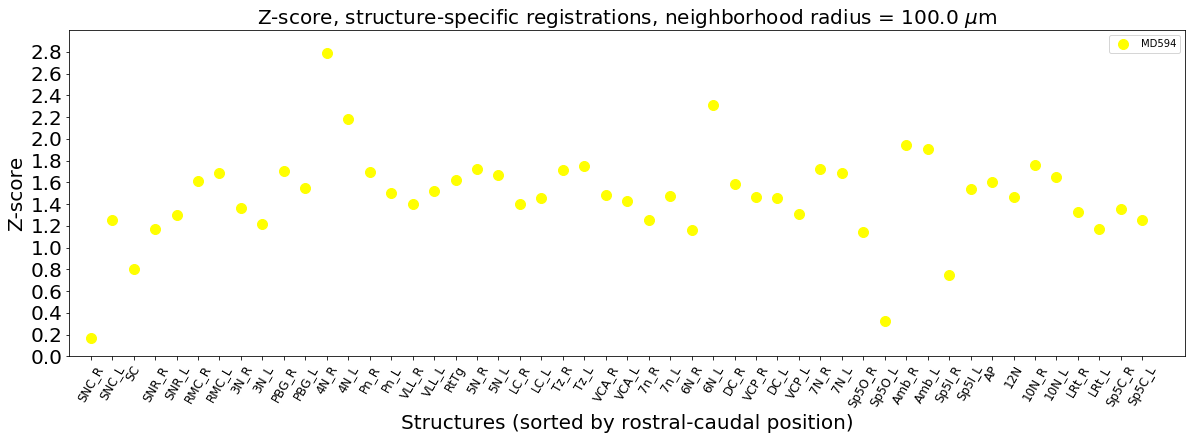

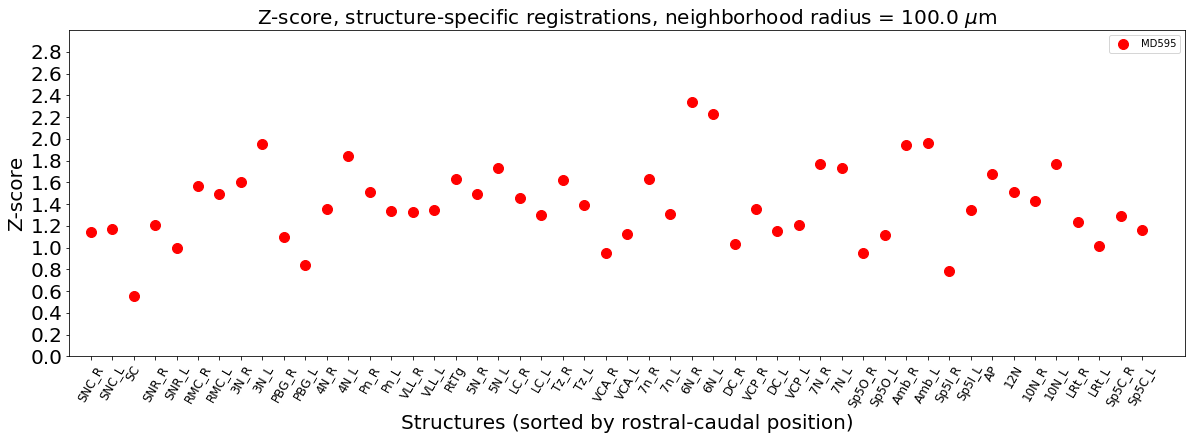

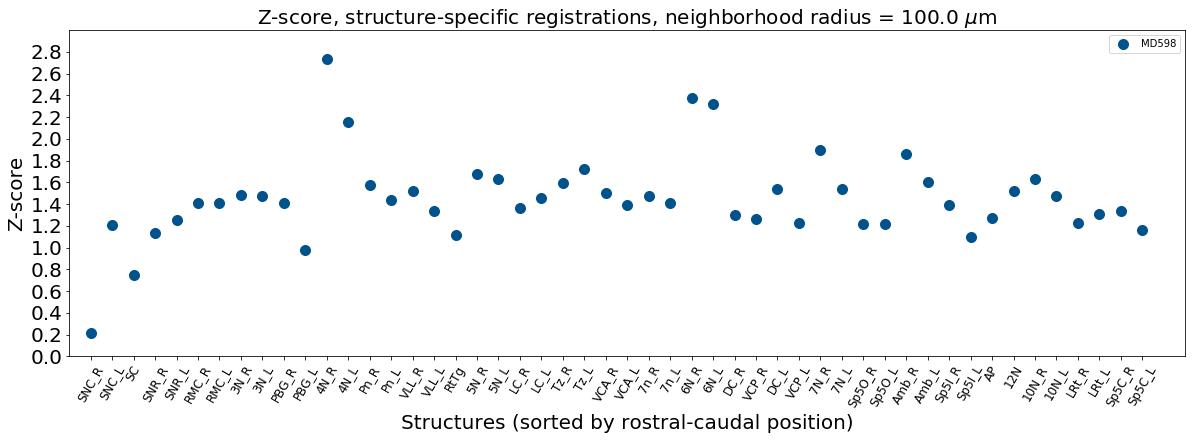

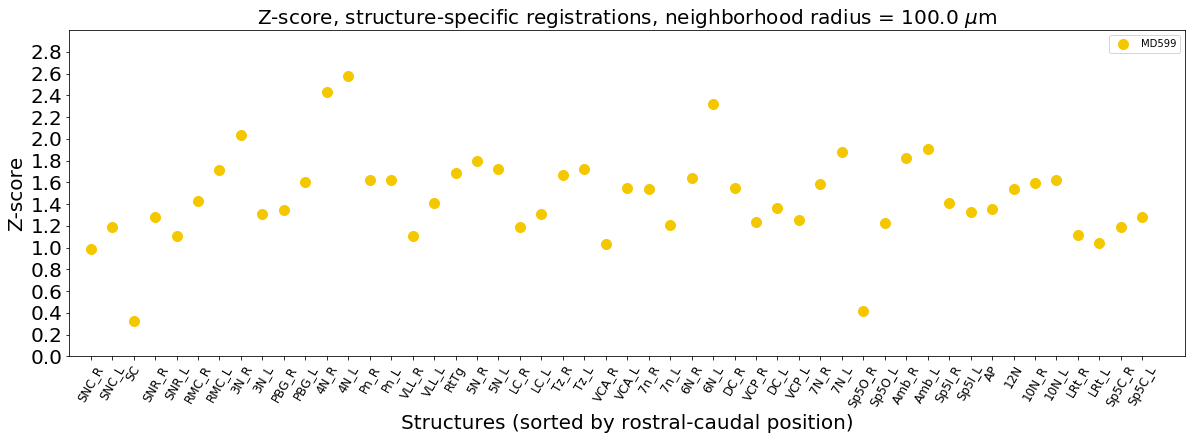

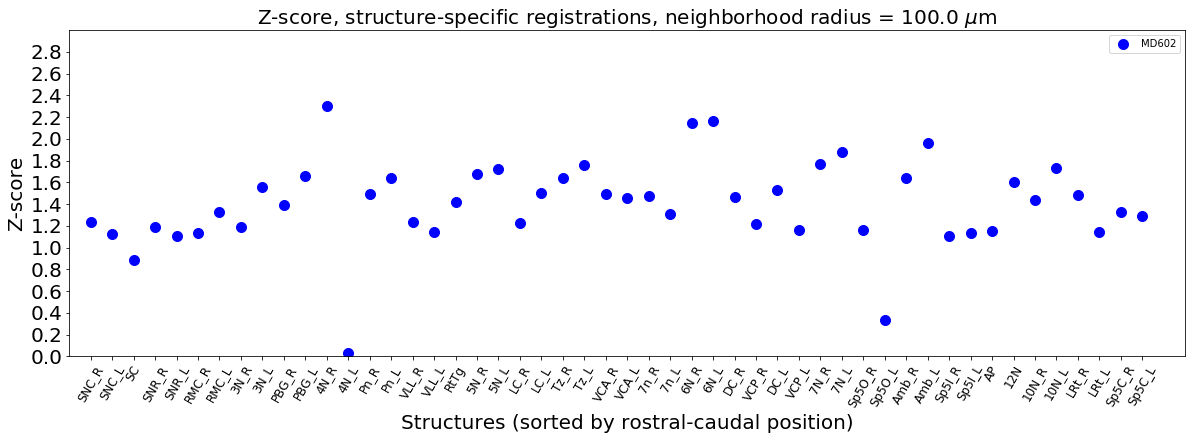

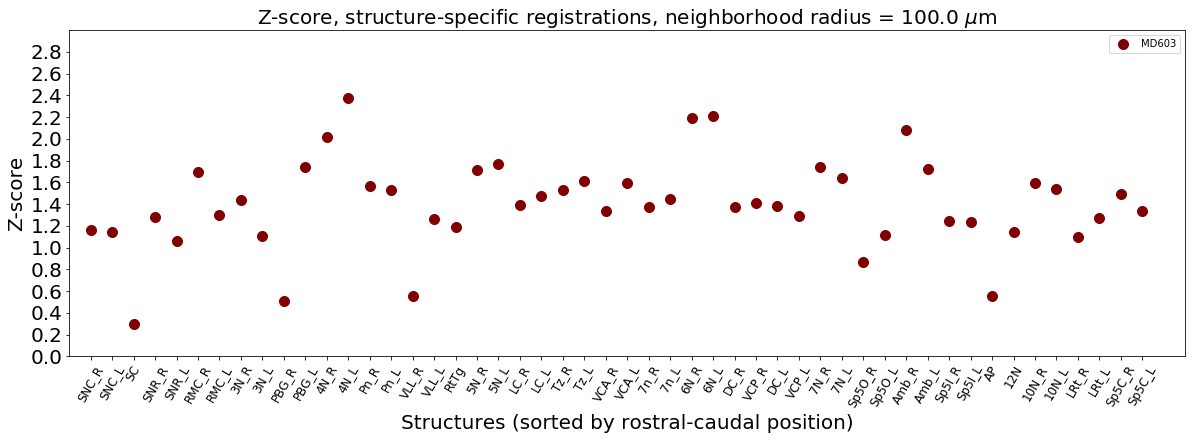

In [16]:
for stack in all_nissl_stacks:

    plot_by_stack_by_structure({stack: zscore_allstacks_allstructures_oneCombination[stack]}, 
                               structures=structures_sided_sorted_by_rostral_caudal_position,
                              stack_to_color=stack_to_color,
                              yticks=np.arange(0, 3, .2),
                               yticklabel_fmt='%.1f',
                              ylabel='Z-score',
                              title='Z-score, structure-specific registrations, neighborhood radius = %.1f $\mu$m' % pool_radius,
                              xlabel='Structures (sorted by rostral-caudal position)',
                               xticks_fontsize=12,
                              );

# Load peak width results

In [39]:
# Encoding with JSON makes integer keys appear as str.

def convert_keys_str_to_int(d):
    return {k: {kk: {int(kkk): {int(kkkk): xxxx for kkkk,xxxx in xxx.iteritems()} for kkk, xxx in xx.iteritems()} 
            for kk, xx in x.iteritems()} 
for k, x in d.iteritems()}

In [40]:
peakradius_max_um_allstacks_allstructures_allsteps_allpools = convert_keys_str_to_int(load_data('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_max_um_allstacks_allstructures_allsteps_allpools.json'))
peakradius_max_normalized_allstacks_allstructures_allsteps_allpools = convert_keys_str_to_int(load_data('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_max_normalized_allstacks_allstructures_allsteps_allpools.json'))
peakradius_min_um_allstacks_allstructures_allsteps_allpools = convert_keys_str_to_int(load_data('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_min_um_allstacks_allstructures_allsteps_allpools.json'))
peakradius_min_normalized_allstacks_allstructures_allsteps_allpools = convert_keys_str_to_int(load_data('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_min_normalized_allstacks_allstructures_allsteps_allpools.json'))
peakradius_x_um_allstacks_allstructures_allsteps_allpools = convert_keys_str_to_int(load_data('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_x_um_allstacks_allstructures_allsteps_allpools.json'))
peakradius_y_um_allstacks_allstructures_allsteps_allpools = convert_keys_str_to_int(load_data('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_y_um_allstacks_allstructures_allsteps_allpools.json'))
peakradius_z_um_allstacks_allstructures_allsteps_allpools = convert_keys_str_to_int(load_data('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/confidence/measurements/peakradius_z_um_allstacks_allstructures_allsteps_allpools.json'))

# Plot margin (least certain direction)

In [41]:
peak_radius_max_um_allstacks_allstructures_oneCombination = {
    stack:
    {struct: x[hessian_stepsize][pool_radius]
    for struct, x in x_per_stack.iteritems()}
    for stack, x_per_stack in peakradius_max_um_allstacks_allstructures_allsteps_allpools.iteritems()
}

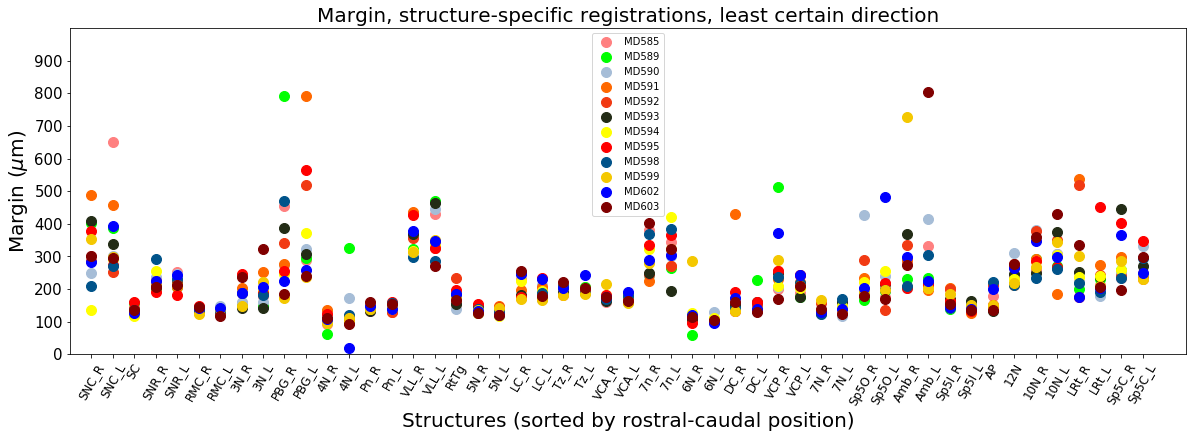

In [42]:
plot_by_stack_by_structure(peak_radius_max_um_allstacks_allstructures_oneCombination, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                          stack_to_color=stack_to_color,
                          yticks=np.arange(0, 1000, 100),
                           yticklabel_fmt='%d',
                          ylabel='Margin ($\mu$m)',
                          title='Margin, structure-specific registrations, least certain direction',
                          xlabel='Structures (sorted by rostral-caudal position)',
                        xticks_fontsize=12,
                           yticks_fontsize=15
);

In [43]:
print 'median local registration peak width:', np.nanmedian([y for x in peak_radius_max_um_allstacks_allstructures_oneCombination.values() for y in x.values()])

median local registration peak width: 192.5375700716678


# Plot normalized margin  (least certain direction)

In [44]:
peak_radius_max_normalized_allstacks_allstructures_oneCombination = {
    stack:
    {struct: x[hessian_stepsize][pool_radius]
    for struct, x in x_per_stack.iteritems()}
    for stack, x_per_stack in peakradius_max_normalized_allstacks_allstructures_allsteps_allpools.iteritems()
}

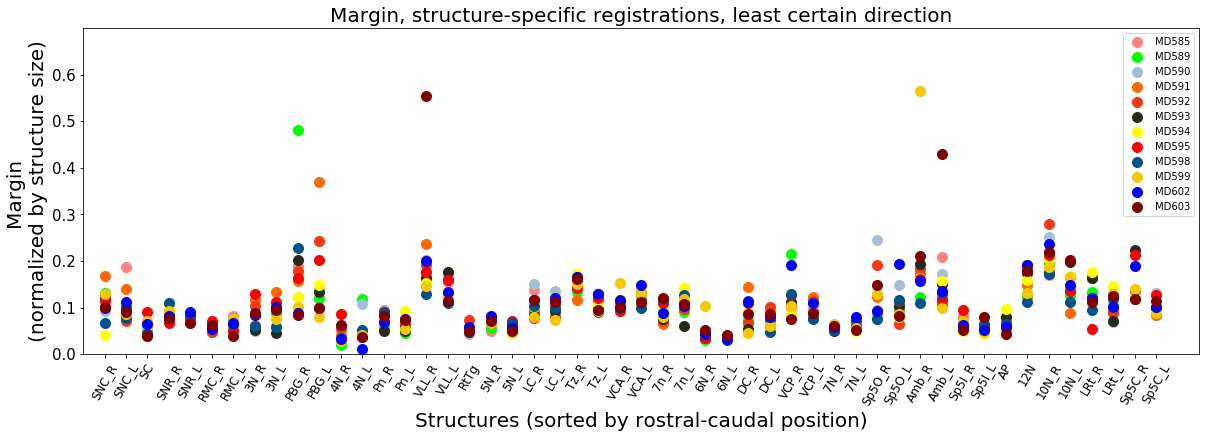

In [43]:
plot_by_stack_by_structure(peak_radius_max_normalized_allstacks_allstructures_oneCombination, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                          stack_to_color=stack_to_color,
                          yticks=np.arange(0, 0.7, 0.1),
                           yticklabel_fmt='%.1f',
                          ylabel='Margin \n(normalized by structure size)',
                          title='Margin, structure-specific registrations, least certain direction',
                           xticks_fontsize=12,
                           yticks_fontsize=15,
                          xlabel='Structures (sorted by rostral-caudal position)');

In [45]:
print 'median local registration peak width (normalized by structure size):', np.nanmedian([y for x in peak_radius_max_normalized_allstacks_allstructures_oneCombination.values() for y in x.values()])

median local registration peak width (normalized by structure size): 0.08927911061664245


# Plot margin (most certain direction)

In [46]:
peak_radius_min_um_allstacks_allstructures_oneCombination = {
    stack:
    {struct: x[hessian_stepsize][pool_radius]
    for struct, x in x_per_stack.iteritems()}
    for stack, x_per_stack in peakradius_min_um_allstacks_allstructures_allsteps_allpools.iteritems()
}

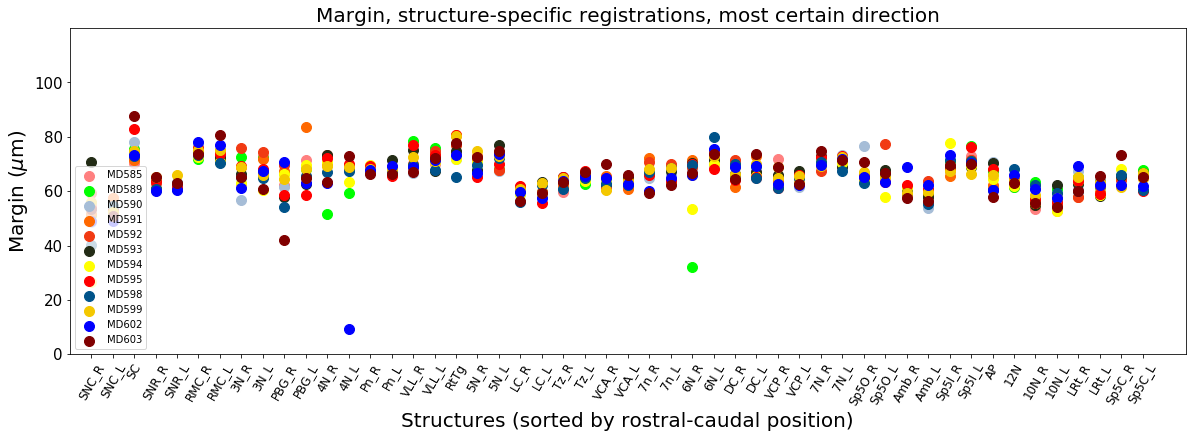

In [47]:
plot_by_stack_by_structure(peak_radius_min_um_allstacks_allstructures_oneCombination, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                          stack_to_color=stack_to_color,
                          yticks=np.arange(0, 101, 20),
                           yticklabel_fmt='%d',
                          ylabel='Margin ($\mu$m)',
                          title='Margin, structure-specific registrations, most certain direction',
                          xlabel='Structures (sorted by rostral-caudal position)',
                        xticks_fontsize=12,
                           yticks_fontsize=15
);

In [48]:
print 'median local registration peak width (most certain direction):', np.nanmedian([y for x in peak_radius_min_um_allstacks_allstructures_oneCombination.values() for y in x.values()])

median local registration peak width (most certain direction): 66.03372422736624


# Plot normalized margin (most certain direction)

In [49]:
peak_radius_min_normalized_allstacks_allstructures_oneCombination = {
    stack:
    {struct: x[hessian_stepsize][pool_radius]
    for struct, x in x_per_stack.iteritems()}
    for stack, x_per_stack in peakradius_min_normalized_allstacks_allstructures_allsteps_allpools.iteritems()
}

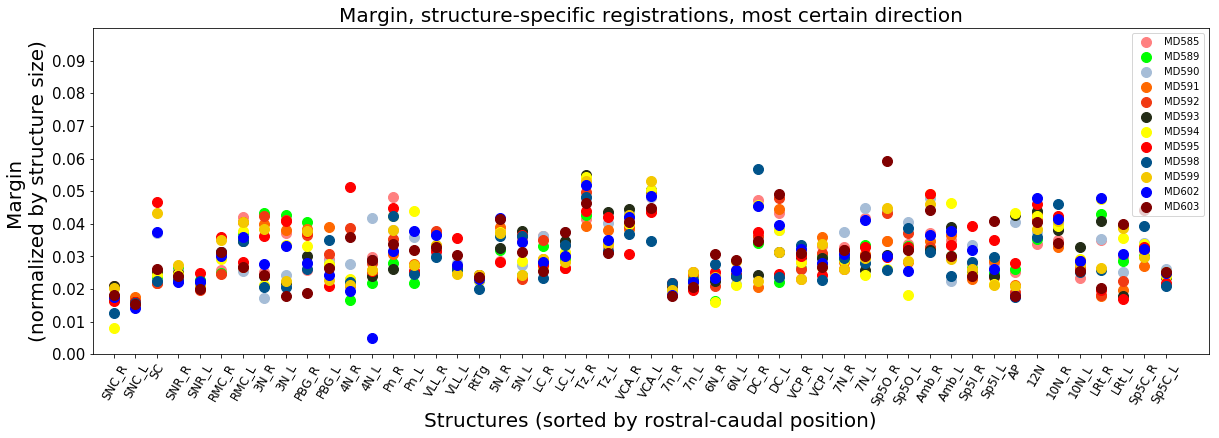

In [50]:
plot_by_stack_by_structure(peak_radius_min_normalized_allstacks_allstructures_oneCombination, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                          stack_to_color=stack_to_color,
                          yticks=np.arange(0, 0.1, 0.01),
                           yticklabel_fmt='%.2f',
                          ylabel='Margin \n(normalized by structure size)',
                          title='Margin, structure-specific registrations, most certain direction',
                           xticks_fontsize=12,
                           yticks_fontsize=15,
                          xlabel='Structures (sorted by rostral-caudal position)');

In [51]:
print 'median local registration peak width (most certain direction) (normalized by structure size):', np.nanmedian([y for x in peak_radius_min_normalized_allstacks_allstructures_oneCombination.values() for y in x.values()])

median local registration peak width (most certain direction) (normalized by structure size): 0.028852020624744727
